**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Load Forecasting N-step ahead with MLP


### Importing Libraries

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

### Defining a robust MLP class

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        """
        Parameters:
        - input_size (int): The size of the input layer.
        - hidden_sizes (list of int): A list containing the sizes of each hidden layer.
        - output_size (int): The size of the output layer.
        - activation (str): The activation function for hidden layers ('relu' or 'tanh').
        - apply_relu_output (bool): Whether to apply ReLU to the output layer.
        """
        super(MLP, self).__init__()
        
        # Store activation function type
        if activation not in ['relu', 'tanh']:
            raise ValueError("Activation function must be either 'relu' or 'tanh'")
        self.activation = activation

        # Create the list of layers
        layers = []
        previous_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            previous_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(previous_size, output_size))
        
        # Register the layers as a ModuleList
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Apply hidden layers with the chosen activation function
        for layer in self.layers[:-1]:
            x = layer(x)
            if self.activation == 'relu':
                x = torch.relu(x)
            elif self.activation == 'tanh':
                x = torch.tanh(x)
        
        # Apply the output layer
        x = self.layers[-1](x)
        
        return x
    
    def predict(self, df):
        """
        Parameters:
        - df (pd.DataFrame): The input DataFrame containing the features.
        
        Returns:
        - np.ndarray: The prediction as a NumPy array.
        """
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            x = torch.tensor(df.values, dtype=torch.float32)
            output = self.forward(x)
        return np.array(output.numpy(), dtype=float)


### Data Loading and Preparation

In [20]:
df = pd.read_csv('../data/data.csv', decimal=',', sep=';')
# extract datetime from date and hour of original df
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str), format="%d/%m/%Y %H")
df['Year'] = pd.to_datetime(df['Date'], format='%d/%m/%Y').dt.year
# numeric day of week
df['DayOfWeek'] = df['datetime'].dt.dayofweek

### Data Scaling

In [21]:
# normalize input features and target
df['P_norm'] = df['P'] / df['P'].max()
df['Test_norm'] = (df['Test'] - df['Test'].min()) / (df['Test'].max() - df['Test'].min())
# norm on max day of week and hour
df['DayOfWeek_norm'] = df['DayOfWeek'] / df['DayOfWeek'].max()
df['Hour_norm'] = df['Hour'] / df['Hour'].max()

In [22]:
# split data into train and test sets based on year 2015 or 2016
train_df = df[df['Year'] == 2015].copy()
test_df = df[df['Year'] == 2016].copy()

In [23]:
def create_forecasting_datasets(data, lag_variables, forward_variables, static_variables=None, lag_steps=3, forward_steps=1):
    """
    Builds a dataset with lagged input features, forward-stepped outputs, and static features for time series forecasting.

    Parameters:
        data (pd.DataFrame): The original dataset containing time series data.
        lag_variables (list): List of column names used as lagged features.
        forward_variables (list): List of column names used as output features.
        static_variables (list, optional): List of column names to be included as-is without lagging or forwarding.
        lag_steps (int): Number of lagged steps for input features.
        forward_steps (int): Number of forward steps for outputs.

    Returns:
        pd.DataFrame: A DataFrame with lagged inputs, forward-stepped outputs, and static features.
    """
    
    # Initialize lists to store lagged, forward-stepped, and static columns
    lagged_data = []
    forward_data = []
    static_data = []

    # Generate lagged features for each input feature
    for feature in lag_variables:
        for lag in range(0, lag_steps):
            lagged_data.append(data[feature].shift(lag).rename(f'{feature}_lag_{lag}'))
    
    # Generate forward-stepped features for each output feature
    for feature in forward_variables:
        for step in range(1, forward_steps + 1):
            forward_data.append(data[feature].shift(-step).rename(f'{feature}_step_{step}'))
    
    # Add static features without any lagging or forwarding
    if static_variables:
        static_data = [data[feature] for feature in static_variables]
    
    # Concatenate the lagged, forward, and static data
    lagged_df = pd.concat(lagged_data, axis=1)
    forward_df = pd.concat(forward_data, axis=1)
    static_df = pd.concat(static_data, axis=1) if static_data else pd.DataFrame()
    
    # Combine all data
    result = pd.concat([lagged_df, static_df, forward_df], axis=1).dropna()
    
    return result


### Prepare the data for training

In [24]:
train_df_prepared_all = create_forecasting_datasets(train_df,
                                                lag_variables=['P_norm'],
                                                forward_variables=['Test_norm', 'P_norm'],
                                                static_variables=['DayOfWeek_norm', 'Hour_norm'],
                                                lag_steps=48,
                                                forward_steps=24)
# sample 10% of train_df_prepared as validation set
val_df_prepared = train_df_prepared_all.sample(frac=0.1, random_state=42)
train_df_prepared = train_df_prepared_all.drop(val_df_prepared.index)

test_df_prepared = create_forecasting_datasets(test_df,
                                               lag_variables=['P_norm'],
                                               forward_variables=['Test_norm', 'P_norm'],
                                               static_variables=['DayOfWeek_norm', 'Hour_norm'],
                                               lag_steps=48,
                                               forward_steps=24)

In [25]:
train_features = torch.FloatTensor(train_df_prepared.values[:, 0:74])
train_targets = torch.FloatTensor(train_df_prepared.values[:, 74:98])
dataset = TensorDataset(train_features, train_targets)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
val_features = torch.FloatTensor(val_df_prepared.values[:, 0:74])
val_targets = torch.FloatTensor(val_df_prepared.values[:, 74:98])
val_dataset = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Setting hyperparameters

In [27]:
# hyperparameters
batch_size = 128
hidden_sizes = [512, 512, 256, 256]
activation = 'relu'
learning_rate = 0.001
epochs = 100

### Model Initialization

In [28]:
model = MLP(len(train_features[0]), 
            hidden_sizes, len(train_targets[0]), activation=activation)

In [29]:
# define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

### Training the model

In [30]:
# train the model
epochs = epochs

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        output = model(inputs)

        # Calculate loss
        loss = criterion(output, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        epoch_loss += loss.item()
    
    # Calculate and print the average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        val_output = model(val_features)
        val_loss = criterion(val_output, val_targets).item()
        
    train_losses.append(avg_epoch_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Training Loss: 0.1101, Validation Loss: 0.0464
Epoch 2/100, Training Loss: 0.0303, Validation Loss: 0.0214
Epoch 3/100, Training Loss: 0.0211, Validation Loss: 0.0223
Epoch 4/100, Training Loss: 0.0201, Validation Loss: 0.0152
Epoch 5/100, Training Loss: 0.0155, Validation Loss: 0.0125
Epoch 6/100, Training Loss: 0.0151, Validation Loss: 0.0108
Epoch 7/100, Training Loss: 0.0130, Validation Loss: 0.0095
Epoch 8/100, Training Loss: 0.0131, Validation Loss: 0.0145
Epoch 9/100, Training Loss: 0.0104, Validation Loss: 0.0091
Epoch 10/100, Training Loss: 0.0105, Validation Loss: 0.0196
Epoch 11/100, Training Loss: 0.0103, Validation Loss: 0.0082
Epoch 12/100, Training Loss: 0.0096, Validation Loss: 0.0217
Epoch 13/100, Training Loss: 0.0087, Validation Loss: 0.0126
Epoch 14/100, Training Loss: 0.0085, Validation Loss: 0.0085
Epoch 15/100, Training Loss: 0.0071, Validation Loss: 0.0048
Epoch 16/100, Training Loss: 0.0082, Validation Loss: 0.0080
Epoch 17/100, Training Loss: 0.00

### Visualizing training validation losses

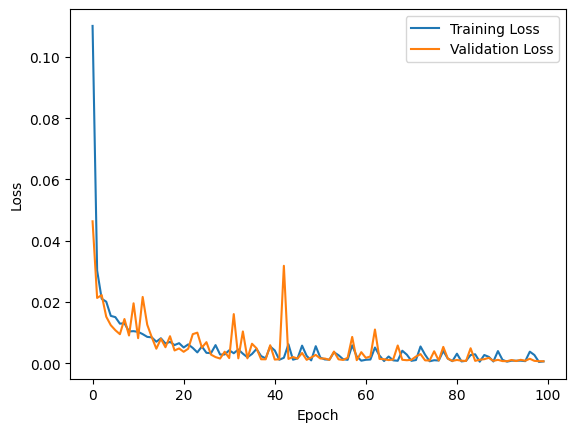

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Compute predictions

In [32]:
train_targets = train_df_prepared.iloc[:, 74:98]
train_predictions = pd.DataFrame(model.predict(train_df_prepared.iloc[:, 0:74]))

test_targets = test_df_prepared.iloc[:, 74:98]
test_predictions = pd.DataFrame(model.predict(test_df_prepared.iloc[:, 0:74]))

### Evaluate the model

In [33]:
# Initialize dictionaries to store metrics for each feature
metrics_per_feature = {'Feature': [], 'MSE': [], 'MAPE': [], 'R2': []}

# Loop through each target feature column and calculate metrics
for i in range(train_targets.shape[1]):
    # Calculate metrics for the training set
    metrics_per_feature['Feature'].append(f'P_lag_{i}')
    metrics_per_feature['MSE'].append(mean_squared_error(train_targets.iloc[:, i], train_predictions.iloc[:, i]))
    metrics_per_feature['MAPE'].append(mean_absolute_percentage_error(train_targets.iloc[:, i], train_predictions.iloc[:, i]))
    metrics_per_feature['R2'].append(r2_score(train_targets.iloc[:, i], train_predictions.iloc[:, i]))

# Convert metrics to DataFrame
train_metrics_df = pd.DataFrame(metrics_per_feature)

# Calculate global metrics for the entire training set
global_metrics = {
    'Metric': ['Global MSE', 'Global MAPE', 'Global R2'],
    'Value': [
        float(mean_squared_error(train_targets.values.flatten(), train_predictions.values.flatten())),
        float(mean_absolute_percentage_error(train_targets.values.flatten(), train_predictions.values.flatten())),
        float(r2_score(train_targets.values.flatten(), train_predictions.values.flatten()))
    ]
}

global_metrics_df = pd.DataFrame(global_metrics)

# Repeat the same for the test set
metrics_per_feature_test = {'Feature': [], 'MSE': [], 'MAPE': [], 'R2': []}

for i in range(test_targets.shape[1]):
    metrics_per_feature_test['Feature'].append(f'P_lag_{i}')
    metrics_per_feature_test['MSE'].append(float(mean_squared_error(test_targets.iloc[:, i], test_predictions.iloc[:, i])))
    metrics_per_feature_test['MAPE'].append(float(mean_absolute_percentage_error(test_targets.iloc[:, i], test_predictions.iloc[:, i])))
    metrics_per_feature_test['R2'].append(float(r2_score(test_targets.iloc[:, i], test_predictions.iloc[:, i])))

# Convert test metrics to DataFrame
test_metrics_df = pd.DataFrame(metrics_per_feature_test)

# Calculate global test metrics
global_metrics_test = {
    'Metric': ['Global Test MSE', 'Global Test MAPE', 'Global Test R2'],
    'Value': [
        float(mean_squared_error(test_targets.values.flatten(), test_predictions.values.flatten())),
        float(mean_absolute_percentage_error(test_targets.values.flatten(), test_predictions.values.flatten())),
        float(r2_score(test_targets.values.flatten(), test_predictions.values.flatten()))
    ]
}

global_metrics_test_df = pd.DataFrame(global_metrics_test)

# Display DataFrames
print("Training Metrics Per Feature:")
print(train_metrics_df)

print("\nGlobal Training Metrics:")
print(global_metrics_df)

print("\nTest Metrics Per Feature:")
print(test_metrics_df)

print("\nGlobal Test Metrics:")
print(global_metrics_test_df)

Training Metrics Per Feature:
     Feature       MSE      MAPE        R2
0    P_lag_0  0.000419  0.044627  0.992523
1    P_lag_1  0.000431  0.044355  0.992325
2    P_lag_2  0.000441  0.042894  0.992163
3    P_lag_3  0.000479  0.048148  0.991502
4    P_lag_4  0.000486  0.045355  0.991395
5    P_lag_5  0.000397  0.042249  0.992960
6    P_lag_6  0.000380  0.039259  0.993231
7    P_lag_7  0.000399  0.042375  0.992866
8    P_lag_8  0.000426  0.041690  0.992387
9    P_lag_9  0.000414  0.041875  0.992626
10  P_lag_10  0.000424  0.044568  0.992460
11  P_lag_11  0.000517  0.049022  0.990809
12  P_lag_12  0.000480  0.047238  0.991475
13  P_lag_13  0.000488  0.047160  0.991329
14  P_lag_14  0.000462  0.045106  0.991789
15  P_lag_15  0.000450  0.042981  0.991997
16  P_lag_16  0.000495  0.043196  0.991192
17  P_lag_17  0.000485  0.042811  0.991406
18  P_lag_18  0.000511  0.042853  0.990954
19  P_lag_19  0.000526  0.043720  0.990681
20  P_lag_20  0.000523  0.044292  0.990706
21  P_lag_21  0.000524  

**NB: the model is not trained on the whole training set since 10% of the data is used as validation set.**

This procedure can be applied when searching for best set of hyperparameters. Once the best set is found, the model can be trained on the whole training set. 